In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lightgbm import LGBMClassifier
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV
import lightgbm as lgb
import re
from sklearn.externals import joblib
import sklearn.metrics as metrics
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%pylab inline
%matplotlib inline

/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ashwin/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
train=pd.read_csv('/home/ashwin/Downloads/happiness/train.csv')
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')

In [3]:
print(train.head())
print(train.shape)
print(test.head())
print(test.shape)

   User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   
3  id10329  Stayed here with husband and sons on the way t...   
4  id10330  My girlfriends and I stayed here to celebrate ...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  
3   InternetExplorer     Desktop       happy  
4               Edge      Tablet   not happy  
(38932, 5)
   User_ID                                        Description  \
0  id80132  Looking for a motel in close proximity to TV t...   
1  id80133  Walking distance to Madison Square Garden and ...   
2  id80134  Visited Seattle on business. Spent - nights in...   
3  id80135  This hotel location is excellent and the roo

In [4]:
le = preprocessing.LabelEncoder()
target=le.fit_transform(train['Is_Response'])
print( np.bincount(target))

[26521 12411]


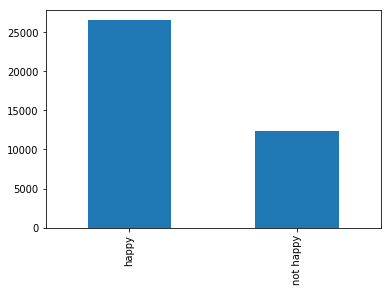

In [5]:
train['Is_Response'].value_counts().plot(kind='bar')

In [6]:
train=train.drop('Is_Response',axis=1)
data=[train,test]
train_test=pd.concat(data,axis=0).reset_index(drop=True)
print(train_test.shape)

(68336, 4)


In [7]:
stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = WordNetLemmatizer()
        txt = " ".join([st.lemmatize(w) for w in txt.split()])

    return txt

In [8]:
#countvec = CountVectorizer(analyzer='word', ngram_range = (1,3), min_df=50, max_features=1500)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,10), min_df =1,
                           max_features=3750)

In [10]:
train_test['Description']=train_test['Description'].map(lambda x:cleanData(x,lowercase=True,remove_stops=True,stemming=True))

In [11]:
list(train_test)

['User_ID', 'Description', 'Browser_Used', 'Device_Used']

In [12]:
#bagofwords = countvec.fit_transform(train_test['Description'])
tfidfdata = tfidfvec.fit_transform(train_test['Description'])
#bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [13]:
Browser_Used=pd.get_dummies(train_test['Browser_Used'])
Device_Used=pd.get_dummies(train_test['Device_Used'])

In [14]:
alldata_tf=pd.concat([tfidf_df,Browser_Used,Device_Used],axis=1)
#alldata_bow=pd.concat([bow_df,Browser_Used,Device_Used],axis=1)
#print(alldata_bow.shape)
print(alldata_tf.shape)

(68336, 3764)

In [14]:
#train_bow=alldata_bow[:len(target)]
train_tf=alldata_tf[:len(target)]
#test_bow=alldata_bow[len(target):]
test_tf=alldata_tf[len(target):]
#print(train_bow.shape,test_bow.shape)
print(train_tf.shape,test_tf.shape)
del alldata_tf
#del alldata_bow

(38932, 3764) (29404, 3764)


In [15]:
sm = SMOTE(random_state=12,ratio=1,n_jobs=-1)
#x_synthitic_data_bow,y_synthitic_data_bow = sm.fit_sample(train_bow, target)
x_synthitic_data_tf,y_synthitic_data_tf = sm.fit_sample(train_tf, target)
#print(x_synthitic_data_bow.shape)
#print( np.bincount(y_synthitic_data_bow))
print(x_synthitic_data_tf.shape)
print( np.bincount(y_synthitic_data_tf))

In [25]:
lgBoost = LGBMClassifier()
param = {'task': ['train'],
         'num_leaves':[200],
         'objective':['binary'],
         'max_depth':[8],
         'learning_rate':[0.05],
         'max_bin':[150],
         'feature_fraction': [0.3], 
         'bagging_fraction': [0.8],
         'metric':['auc']}
clf = GridSearchCV(lgBoost, param_grid=param, n_jobs=1, 
                   cv=StratifiedKFold(y_synthitic_data_bow, n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
clf.fit(x_synthitic_data_bow,y_synthitic_data_bow)
predictions=clf.predict(train_bow)
print('lightboost Classifier train/validation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)

test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
predictions=clf.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylgbbow.csv',index=False)

In [26]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
lgBoost_tf = LGBMClassifier()
param = {'task': ['train'],
         'num_leaves':[200],
         'objective':['binary'],
         'max_depth':[8],
         'learning_rate':[0.05],
         'max_bin':[150],
         'feature_fraction': [0.3], 
         'bagging_fraction': [0.8],
         'metric':['auc']}
clf1 = GridSearchCV(lgBoost, param_grid=param, n_jobs=1, 
                   cv=StratifiedKFold(y_synthitic_data_tf, n_folds=3, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
clf1.fit(x_synthitic_data_tf,y_synthitic_data_tf)
predictions=clf1.predict(train_tf)
print('lightboost Classifier train/validation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)
predictions=clf1.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylgbtf.csv',index=False)

lightboost Classifier train/validation result
accuracy 0.801859652728
recall 0.577068729353
precision 0.743949309234
auc-roc 0.742061758063


In [27]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
n_estimators=20
model=BaggingClassifier(SVC(C=500,kernel='rbf',gamma=0.01,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model.fit(x_synthitic_data_bow,y_synthitic_data_bow)
joblib.dump(model, 'xgboosthappybow.pkl', compress=True)
predictions=model.predict(train_bow)
print('SVM Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)
predictions=model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf.csv'
                  ,index=False)

In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
n_estimators=20
model1=BaggingClassifier(SVC(C=500,kernel='rbf',gamma=0.01,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model1.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(model1, 'xgboosthappytf.pkl', compress=True)
predictions=model1.predict(train_tf)
print('SVM Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)

predictions=model1.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf1.csv',index=False)

SVM Classifier train/valadiation result


accuracy 0.903909380458


recall 0.873499315124
precision 0.833154011682


auc-roc 0.89581982837


In [20]:
predictions=model1.predict(train_tf)
print('SVM Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
pd.crosstab(target, predictions, rownames=['True'], 
            colnames=['Predicted'], margins=True)

predictions=model1.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf1.csv',index=False)

SVM Classifier train/valadiation result


accuracy 0.900467481763


recall 0.871807267746
precision 0.825702075702


auc-roc 0.892843417441


In [25]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
model = RandomForestClassifier(n_estimators = 500, oob_score = True, 
                n_jobs = -1,random_state =50,max_features = "auto"
                                   , min_samples_leaf = 3)
model.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(model, 'xgboostrf.pkl', compress=True)
predictions=model.predict(train_tf)
print('RandomForest Classifier train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))


predictions=model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happyrf.csv',index=False)

RandomForest Classifier train/valadiation result
accuracy 0.980966813932
recall 0.949722020788
precision 0.990171370968
auc-roc 0.972655211216


In [3]:
x_synthitic_data_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/synthitic_tf.csv'
              , delimiter=',')
y_synthitic_data_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/y_synthitic_data_tf.csv', delimiter=',')


In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
model=LogisticRegression()
grid_values = {'penalty': ['l2'], 'C': [0.001,0.005,0.01,0.05,0.1
    ,0.5,1,10,100,1000],
               'solver' : ['lbfgs'],
               'max_iter':[4000]}
logistic_model = GridSearchCV(model, param_grid=grid_values,
                cv=StratifiedKFold(y_synthitic_data_tf, n_folds=3, shuffle=True),
                n_jobs=-1,scoring='roc_auc',refit=True)
logistic_model.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(logistic_model, 'xgboostlogistic.pkl', compress=True)
print(logistic_model.best_params_,logistic_model.best_score_)
del x_synthitic_data_tf
del y_synthitic_data_tf





{'C': 1, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'lbfgs'} 0.9649829290814684


In [ ]:
predictions=logistic_model.predict(train_tf)
print('Logistic Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))

Logistic Regression Classifier Train/valadiation result
accuracy 0.909508887291
recall 0.894045604706
precision 0.834034876729


auc-roc 0.905395412737


In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
predictions=logistic_model.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happylogistic.csv',index=False)

In [17]:
#np.savetxt('/home/ashwin/Downloads/happiness/synthitic_bow.csv'
 #          ,x_synthitic_data_bow,delimiter=',')
#np.savetxt('/home/ashwin/Downloads/happiness/y_synthitic_data_bow.csv'
 #          ,y_synthitic_data_bow,delimiter=',')
np.savetxt('/home/ashwin/Downloads/happiness/synthitic_tf.csv'
          ,x_synthitic_data_tf,delimiter=',')
np.savetxt('/home/ashwin/Downloads/happiness/y_synthitic_data_tf.csv'
         ,y_synthitic_data_tf,delimiter=',')

In [24]:
x_synthitic_data_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/synthitic_tf.csv'
              , delimiter=',')
y_synthitic_data_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/y_synthitic_data_tf.csv', delimiter=',')

naive_byase = BernoulliNB()
naive_byase.fit(x_synthitic_data_tf,y_synthitic_data_tf)
joblib.dump(naive_byase, 'xgboostnaive.pkl', compress=True)
del x_synthitic_data_tf
del y_synthitic_data_tf
predictions=naive_byase.predict(train_tf)
print('naive byas Regression Classifier Train/valadiation result')
print('accuracy',metrics.accuracy_score(target,predictions))
print('recall',metrics.recall_score(target,predictions))
print('precision',metrics.precision_score(target,predictions))
print('auc-roc',metrics.roc_auc_score(target,predictions))
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
predictions=naive_byase.predict(test_tf)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happynaive.csv',index=False)

Logistic Regression Classifier Train/valadiation result
accuracy 0.718072536731
recall 0.413826444283
precision 0.581192712459
auc-roc 0.637138326776


In [6]:
train_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/train_tf.csv'
           ,delimiter=',')
test_tf=np.genfromtxt('/home/ashwin/Downloads/happiness/test_tf.csv'
          ,delimiter=',')
target=np.genfromtxt('/home/ashwin/Downloads/happiness/target.csv'
          ,delimiter=',')

In [15]:
clf1= joblib.load('xgboostrf.pkl') 
predictions1=clf1.predict(train_tf)

In [16]:
clf2= joblib.load('xgboosthappytf.pkl') 
predictions2=clf2.predict(train_tf)

In [17]:
clf3= joblib.load('xgboostlogistic.pkl')
predictions3=clf3.predict(train_tf)

In [ ]:



np.savetxt('/home/ashwin/Downloads/happiness/train_tf.csv'
          ,train_tf,delimiter=',')
np.savetxt('/home/ashwin/Downloads/happiness/test_tf.csv'
         ,test_tf,delimiter=',')
np.savetxt('/home/ashwin/Downloads/happiness/target.csv'
         ,target,delimiter=',')


In [18]:
nn_csv=pd.DataFrame()
#nn_csv['clf1_1']=[x[0] for x in predictions1]
#nn_csv['clf1_2']=[x[1] for x in predictions1]
#nn_csv['clf2_1']=[x[0] for x in predictions2]
#nn_csv['clf2_2']=[x[1] for x in predictions2]
#nn_csv['clf3_1']=[x[0] for x in predictions3]
#nn_csv['clf3_2']=[x[1] for x in predictions3]
nn_csv['clf1_1']=predictions1
nn_csv['clf1_2']=predictions2
nn_csv['clf1_3']=predictions3
nn_csv.to_csv('/home/ashwin/Downloads/happiness/nncsv.csv',index=False)

In [19]:
nn = MLPClassifier(hidden_layer_sizes=(300,300,300))
param = {'activation':['relu','logistic','tanh']}
nn_clf1 = GridSearchCV(nn, param_grid=param, n_jobs=-11, 
                   cv=StratifiedKFold(target, n_folds=3, shuffle=True), 
                   scoring='roc_auc',
                   refit=True)
nn_clf1.fit(nn_csv,target)
joblib.dump(nn_clf1, 'xgboostnn.pkl', compress=True)

['xgboostnn.pkl']

In [21]:
#clf1= joblib.load('xgboostrf.pkl') 
predictions1=clf1.predict(test_tf)
#clf2= joblib.load('xgboosthappytf.pkl') 
predictions2=clf2.predict(test_tf)
#clf3= joblib.load('xgboostlogistic.pkl')
predictions3=clf3.predict(test_tf)
nn_csv_test=pd.DataFrame()
#nn_csv_test['clf1_1']=[x[0] for x in predictions1]
#nn_csv_test['clf1_2']=[x[1] for x in predictions1]
#nn_csv_test['clf2_1']=[x[0] for x in predictions2]
#nn_csv_test['clf2_2']=[x[1] for x in predictions2]
#nn_csv_test['clf3_1']=[x[0] for x in predictions3]
#nn_csv_test['clf3_2']=[x[1] for x in predictions3]
nn_csv_test['clf1_1']=predictions1
nn_csv_test['clf1_2']=predictions2
nn_csv_test['clf1_3']=predictions3
#nn_csv.to_csv('/home/ashwin/Downloads/happiness/nncsv.csv',index=False)


In [21]:
nn_pred=nn_clf1.predict(nn_csv_test)
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
predictions1=['happy' if(x==0) else 'not_happy' for x in nn_pred ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/nnsubmission.csv',index=False)

In [ ]:
test=pd.read_csv('/home/ashwin/Downloads/happiness/test.csv')
n_estimators=20
model1=BaggingClassifier(SVC(C=500,kernel='rbf',gamma=0.01,
     probability=True)
    , max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=-1)
model1.fit(nn_csv,target)


predictions=model1.predict(nn_csv_test)
predictions1=['happy' if(x==0) else 'not_happy' for x in predictions ]
submission=pd.DataFrame()
submission['User_ID']=test['User_ID']
submission['Is_Response']=predictions1
submission.to_csv('/home/ashwin/Downloads/happiness/happysvmtf1combain.csv',index=False)
